<a href="https://colab.research.google.com/github/Jayrbsn/image-classification-transfer-learning/blob/main/image_classification_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Cell 1: imports and config
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = 224    # MobileNetV2 typical input
BATCH_SIZE = 32


In [3]:
# Cell 2: load tf_flowers (80/20 split)
(ds_train, ds_val), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,   # returns (image, label)
    with_info=True
)

num_classes = ds_info.features['label'].num_classes
class_names = ds_info.features['label'].names

print("Num classes:", num_classes)
print("Class names:", class_names)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.G8GH57_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Num classes: 5
Class names: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [4]:
# Cell 3: preprocessing + batching
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def preprocess(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)   # scales to [-1, 1] for MobileNetV2
    return image, label

ds_train = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

ds_val = ds_val.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("Train batches:", tf.data.experimental.cardinality(ds_train).numpy())
print("Val batches:  ", tf.data.experimental.cardinality(ds_val).numpy())


Train batches: 92
Val batches:   23


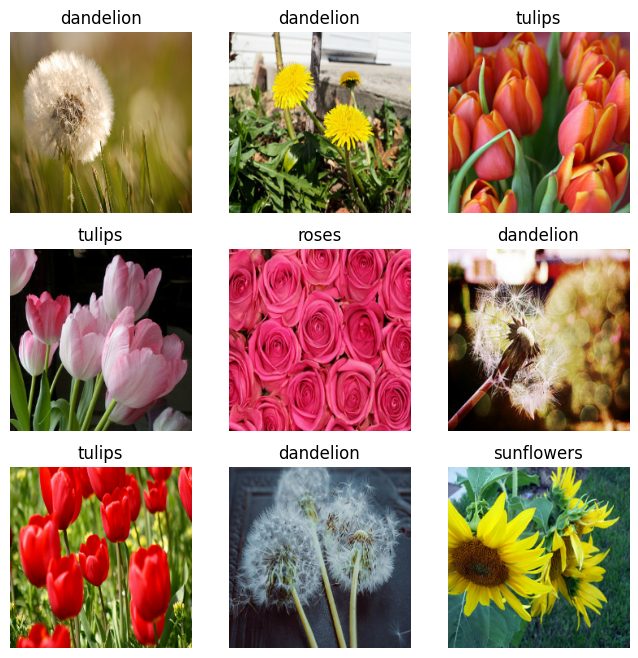

In [5]:
# Cell 4: plot a few training images (convert from [-1,1] to [0,1] for display)
plt.figure(figsize=(8,8))
for images, labels in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        img = images[i].numpy()
        img = (img + 1.0) / 2.0   # [-1,1] -> [0,1]
        plt.imshow(img)
        plt.title(class_names[int(labels[i])])
        plt.axis('off')


In [6]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

# Load MobileNetV2 base (pretrained on ImageNet), exclude top classification layers
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,   # exclude default Dense layers
    weights='imagenet'
)

# Freeze base model weights (so we only train the top layers first)
base_model.trainable = False

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [8]:
EPOCHS = 5  # start small; can increase after testing

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS
)


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 94s 980ms/step - accuracy: 0.5838 - loss: 1.0562 - val_accuracy: 0.8515 - val_loss: 0.4457
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 923ms/step - accuracy: 0.8745 - loss: 0.3763 - val_accuracy: 0.8937 - val_loss: 0.3285
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 928ms/step - accuracy: 0.9091 - loss: 0.2930 - val_accuracy: 0.8992 - val_loss: 0.3020
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.9272 - loss: 0.2432 - val_accuracy: 0.9128 - val_loss: 0.2807
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 126s 974ms/step - accuracy: 0.9439 - loss: 0.2057 - val_accuracy: 0.9074 - val_loss: 0.2714


In [9]:
val_loss, val_acc = model.evaluate(ds_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 774ms/step - accuracy: 0.9078 - loss: 0.2748
Validation Loss: 0.2714
Validation Accuracy: 0.9074


In [10]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Recompile with a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune
fine_tune_epochs = 5
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(
    ds_train,
    validation_data=ds_val,
    initial_epoch=history.epoch[-1],
    epochs=total_epochs
)


Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 369s 4s/step - accuracy: 0.7933 - loss: 0.5618 - val_accuracy: 0.9155 - val_loss: 0.2561
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 380s 4s/step - accuracy: 0.9031 - loss: 0.3107 - val_accuracy: 0.9114 - val_loss: 0.2474
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 389s 4s/step - accuracy: 0.9267 - loss: 0.2399 - val_accuracy: 0.9114 - val_loss: 0.2428
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 335s 4s/step - accuracy: 0.9322 - loss: 0.2063 - val_accuracy: 0.9142 - val_loss: 0.2396
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 343s 4s/step - accuracy: 0.9550 - loss: 0.1613 - val_accuracy: 0.9183 - val_loss: 0.2371
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 381s 4s/step - accuracy: 0.9615 - loss: 0.1322 - val_accuracy: 0.9223 - val_loss: 0.2275


In [11]:
model.save("mobilenetv2_flowers.h5")
print("Model saved as mobilenetv2_flowers.h5")


Model saved as mobilenetv2_flowers.h5


In [12]:
from tensorflow.keras.models import load_model

# Load the trained model
loaded_model = load_model("mobilenetv2_flowers.h5")
print("Model loaded successfully!")


Model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


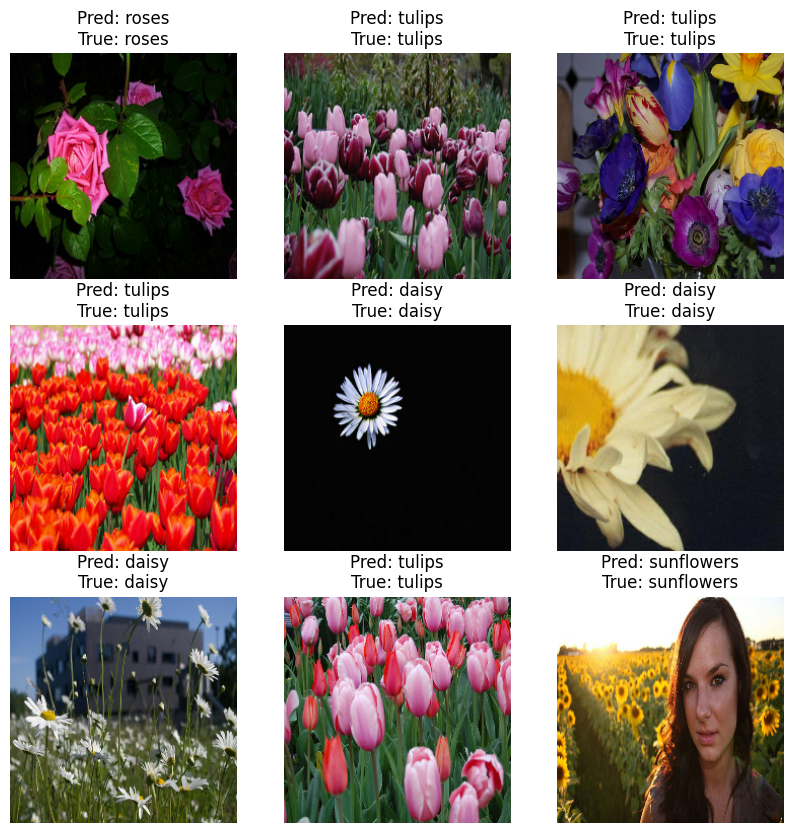

In [13]:
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in ds_val.take(1):
    preds = loaded_model.predict(images)
    pred_classes = np.argmax(preds, axis=1)

    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        img = (images[i].numpy() + 1.0) / 2.0  # [-1,1] -> [0,1]
        plt.imshow(img)
        plt.title(f"Pred: {class_names[pred_classes[i]]}\nTrue: {class_names[int(labels[i])]}")
        plt.axis("off")
plt.show()


In [15]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Path to your test image (replace with your file path)
img_path = "test_flower.jpg"

# Load and preprocess
img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # shape (1, IMG_SIZE, IMG_SIZE, 3)
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

# Predict
preds = loaded_model.predict(img_array)
pred_class = np.argmax(preds, axis=1)[0]

# Display
plt.imshow(image.load_img(img_path))
plt.title(f"Predicted: {class_names[pred_class]}")
plt.axis("off")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'test_flower.jpg'